In [253]:
from pyuvdata import UVBeam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from beam_map_sbf import GetBeamMap 
from scipy.interpolate import RegularGridInterpolator
from matplotlib.lines import Line2D
import psutil

In [2]:
process = psutil.Process()
mem = process.memory_info().rss / 1024**2  # in MB
print(f"Memory usage: {mem:.2f} MB")

# Post August, 2022
D3A_ALT_deg = 80.5 # This is the elevation of the dish from horizon
D3A_AZ_deg = 0 # new
D3A_ALT = D3A_ALT_deg * np.pi/180
D3A_AZ = D3A_AZ_deg * np.pi/180

Memory usage: 198.67 MB


In [3]:
parsed_data_directory = "../parsed_data/"
day = "August_29_port2B_satellite_dict_all_L1.npy"
sat_dict = np.load(parsed_data_directory + day , allow_pickle=True).item()  # extracting saved dictionary

beam_map = GetBeamMap(data_direcs=[])
beam_map.replace_dictionary(sat_dict)

# Load beam data
beam = UVBeam()
beam.read_beamfits('/Users/sabrinaberger/Current Research Local/mitiono/new_beam_data_2024/beam.fits',
                   use_future_array_shapes=True)
power_beam_sim = beam.efield_to_power(inplace=False, calc_cross_pols=True)

Total number of near beam satellites is 0.
R05 passes close to center of beam.
0.0
0.0
Minimum azimuth: 0.0
Corresponding elevation: 3.300003000000004
Minimum elevation: 0.0
Corresponding azimuth: 5.88
R08 passes close to center of beam.
0.02001999999998816
0.009995000000003529
Minimum azimuth: 0.02001999999998816
Corresponding elevation: 0.6899949999999961
Minimum elevation: 0.009995000000003529
Corresponding azimuth: 119.449997
E15 passes close to center of beam.
0.04
0.49000499999999647
Minimum azimuth: 0.04
Corresponding elevation: 0.5200040000000001
Minimum elevation: 0.49000499999999647
Corresponding azimuth: 2.91
R13 passes close to center of beam.
0.02001999999998816
0.009995000000003529
Minimum azimuth: 0.02001999999998816
Corresponding elevation: 9.270004
Minimum elevation: 0.009995000000003529
Corresponding azimuth: 3.869995000000017
E26 passes close to center of beam.
0.02
0.0
Minimum azimuth: 0.02
Corresponding elevation: 0.47000099999999634
Minimum elevation: 0.0
Correspo

In [487]:
print(len(sat_dict))

85


In [42]:
E_36_sat_info = beam_map.save_satellite_arrays("E36")
G_04_sat_info = beam_map.save_satellite_arrays("G04")

In [5]:
print(E_36_sat_info)

{'raw': {'elevs': array([0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ]), 'az': array([96.82, 96.82, 96.82, ..., 13.45, 13.45, 13.45]), 'cnos': array([32.    , 31.9375, 31.6875, ..., 21.25  , 19.125 , 20.375 ]), 'times_cno': array([195204., 195205., 195206., ..., 459324., 459325., 459369.]), 'times_elevs': array([193675., 193676., 193677., ..., 461935., 461936., 461937.])}, 'matched': {'times_elevs': array([195204., 195205., 195206., ..., 459324., 459325., 459369.]), 'cnos': array([32.    , 31.9375, 31.6875, ..., 21.25  , 19.125 , 20.375 ]), 'elevs_deg': array([7.13, 7.14, 7.14, ..., 9.45, 9.44, 9.32]), 'az_deg': array([90.849998, 90.829994, 90.829994, ..., 22.59    , 22.58    ,
       22.4     ])}}


In [532]:
from scipy.stats import binned_statistic_2d

def make_plot_full_tracks(all_sat_dict, all_sat, plot_title, sat_list=[], show_power=False, filename="all_sat.png"):
    """
    Plot all the satellites or a subset
    param: all_sat - boolean when true all satellites are plotted, when false, looks for satellite in sat_list
    param: plot_title - title above plot to be generated
    param: direc - directory where to save the plot
    param: filename - name of plot you're making
    """
    if all_sat:
        sats_to_plot = all_sat_dict
    else:
        sats_to_plot = sat_list

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # sorry to not vectorize the below yikes
    powers_arr = []
    az_arr = []
    alt_arr = []

    # below in this for loop I'm binning each az,alt power
    for i, key in enumerate(sats_to_plot):
        satellite = all_sat_dict[key]
        for i, sat_typ in enumerate(satellite['sig_type'][0]): # checking to make sure only using L1
            if sat_typ is not None:
                if "L1" not in sat_typ:
                    print(sat_typ)
                    print("Not using L1")
                    exit()
        cnos = satellite["cno"][0]
        times_cno = satellite["times"][0]
        times_elevs = satellite["elev_time"][0]
        elevs = satellite["elevations"][0]
        az = satellite["azimuths"][0]

        if show_power:
            times_elevs, cnos_matched, elevs_matched, az_matched = beam_map.match_elevs(times_cno, times_elevs, cnos, elevs, az)
            powers_arr.append(cnos_matched)
            alt_arr.append(elevs_matched)
            az_arr.append(az_matched)
        else: # just plotting tracks in black
            ax.scatter(np.deg2rad(az), np.deg2rad(elevs) / (np.pi/2), s=0.01, c="k")
            print(np.deg2rad(az[:2]), elevs[:2])

    if show_power:
        # flattening ragged numpy arrays
        powers_arr = np.concatenate(powers_arr)
        alt_arr = np.concatenate(alt_arr)
        # shifting elevs
        alt_arr = 90 - alt_arr # so 90 is now 0 
        az_arr = np.concatenate(az_arr)
        # 2D binning getting maximums, using ChatGPT to help accelerate generating this plot
        # Step 1: Define bin edges for azimuth and altitude (in degrees)
        alt_bins = np.linspace(0, 90, int(100))  # Altitude bins (0 to 90 degrees), binwidth = 0.1 deg
        az_bins = np.linspace(0, 360, int(100))  # Azimuth bins (-180 to 180 degrees), binwidth = 0.1 deg

        # Step 2: Perform 2D binning using the average of `powers_arr` for each bin
        peaks, az_edges, alt_edges, binnumber = binned_statistic_2d(
            az_arr, alt_arr, powers_arr, statistic='max', bins=[az_bins, alt_bins]
        )

        # Step 3: Convert bin edges to centers for plotting
        az_centers = (az_edges[:-1] + az_edges[1:]) / 2  # Convert azimuth edges to bin centers
        alt_centers = (alt_edges[:-1] + alt_edges[1:]) / 2  # Convert altitude edges to bin centers


        # Step 4: Convert azimuth and altitude to radians for polar plotting
        azimuth_bin_centers, altitude_bin_centers = np.meshgrid(np.radians(az_centers), np.radians(alt_centers))

        # Step 5: Create the polar plot with pcolormesh
        # pcolormesh using binned azimuth and altitude
        r_bin_centers = (altitude_bin_centers) /(np.pi/4) # need over 4 to get scaling right
        c = ax.pcolormesh(azimuth_bin_centers, r_bin_centers, peaks.T[:-1, :-1], cmap='viridis', shading="flat")
        cbar = fig.colorbar(c, ax=ax)
        cbar.set_label(r'$C/N_0$ [dB-Hz]', rotation=270, labelpad=15)


    # Define the center of the circle
    D3A_ALT_deg = 80.5  # This is the elevation of the dish from horizon
    D3A_AZ_deg = 0      # new
    
    # Convert to the same coordinate system used in your plot
    # For elevation: you use 90 - elevation, so the center should be:
    alt_center_transformed = 90 - D3A_ALT_deg  # This gives 9.5 degrees
    az_center = D3A_AZ_deg  # This is 0 degrees
    
    # Convert to radians and apply the same scaling as your plot
    r_center = np.radians(alt_center_transformed) / (np.pi/4)  # Match your r_bin_centers scaling
    theta_center = np.radians(az_center)
    
    # Define circle radius (you can adjust this size as needed)
    circle_radius = 1.22 * 0.2 / 6    
    circle_radius_scaled = circle_radius / (np.pi/4)  # Apply same scaling
    
    # Create the circle
    theta_circle = np.linspace(0, 2 * np.pi, 200)
    x_circle = r_center + circle_radius_scaled * np.cos(theta_circle)
    y_circle = circle_radius_scaled * np.sin(theta_circle)
    
    # Convert back to polar coordinates for plotting
    r_circle = np.sqrt(x_circle**2 + y_circle**2)
    theta_circle_plot = np.arctan2(y_circle, x_circle) + theta_center
    
    ax.plot(theta_circle_plot, r_circle, color='black', linewidth=0.5, linestyle='-')

    # Format plot
    ax.set_theta_zero_location('N')  # 0° azimuth at top
    ax.set_theta_direction(-1)  # Clockwise

    ax.set_rticks([0, np.pi / 4, np.pi / 2]) #, 3 * np.pi / 4, np.pi])
    ax.set_yticklabels(['0°', '45°', '90°']) #, '135°', '180°'])

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

In [533]:
make_plot_full_tracks(all_sat_dict=beam_map.all_sat_dict, show_power=True, all_sat=True, plot_title=r"${\rm Approx. 72 ~ hours ~ of ~ GNSS ~ satellite ~ tracks ~ at ~ D3A}$", filename=f"{day}_all_sat.png")

In [527]:
D3A_ALT_deg

80.5

In [426]:
def plot_raw_polar_beam(beam_power, freq_idx=0, db_scale=True, cmap='viridis', interp_now=False, phi_pass=phi_pass, theta_pass=theta_pass, matched_cnos=cnos, vmin=None, vmax=None):
    """
    Plot raw beam power in polar coordinates (no interpolation).
    - θ=0 (zenith) at center
    - φ=0 (North) at top
    - Clockwise azimuth

    Input angles in DEGREES
    
    Args:
        beam_power: [49, 181, 360] array from calculate_beam_power()
        freq_idx: Frequency index (0-48)
        db_scale: Plot in dB if True
        cmap: Colormap name
        vmin/vmax: Color scale limits
    """
    
    # Center values from beam object
    phi = beam.axis1_array    # shape: [360], range: 0 to 2π
    theta = beam.axis2_array  # shape: [181], range: 0 to π
    print(np.max(theta))
    # Convert to edges
    def compute_edges(x):
        dx = np.diff(x) / 2
        # make edges below
        return np.concatenate([
            [x[0] - dx[0]],
            x[:-1] + dx,
            [x[-1] + dx[-1]]
        ])

    theta_edges = compute_edges(theta)  # shape: [182]
    phi_edges = compute_edges(phi)      # shape: [361]
    
    # Create meshgrid for plotting
    phi_grid, r_grid = np.meshgrid(phi_edges, theta_edges)  # shapes: [361, 182]
    r_pass = r_grid / (np.pi/2)
    # Create plot
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    e_field = beam.data_array  # shape: (2, 2, 49, 181, 360)

    # Get both components for one polarization at one frequency
    selected = e_field[:, 0, freq_idx, :, :]  # shape: (2, 181, 360)
    sim_power_beam = np.sum(np.abs(selected)**2, axis=0)  # shape: (181, 360)
    sim_power_beam = 10 * np.log10(sim_power_beam)
    # Plot raw data with shading='flat' (requires edges)
    c = ax.pcolormesh(
        phi_grid,        # Azimuth edges [361]
        r_grid,          # Radial edges [182]
        sim_power_beam,           # [181, 360] power values
        cmap=cmap,
        shading='flat',  # Now compatible with edges
        # vmin=vmin,
        # vmax=vmax,
    )
    
    # Format plot
    ax.set_theta_zero_location('N')      # 0° azimuth at top
    ax.set_theta_direction(-1)           # Clockwise

    ax.set_rticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    ax.set_yticklabels(['0°', '45°', '90°', '135°', '180°'])

    
    if interp_now:
        r_pass = (np.radians(theta_pass) / np.pi)
        ax.scatter(phi_pass, r_pass, c="black", linewidth=2, cmap=cmap, label='Satellite Path', marker="*")
        ax.legend(loc='lower right', fontsize=10)

    # Colorbar
    cbar = plt.colorbar(c, pad=0.1)
    cbar.set_label('Intensity [dB]', fontsize=14)
    
    plt.title(f'Simulated D3A Beam Intensity at {beam.freq_array[freq_idx]/1e6:.2f} MHz', pad=20, fontsize=14)
    plt.tight_layout()
    if interp_now:
        plt.savefig(f"/Users/sabrinaberger/Desktop/beam_paper_plots/with_path_{beam.freq_array[freq_idx]/1e6:.2f}.png", dpi=300)
    else:
        plt.savefig(f"/Users/sabrinaberger/Desktop/beam_paper_plots/{beam.freq_array[freq_idx]/1e6:.2f}.png", dpi=300)
    plt.show()


3.141592653589793


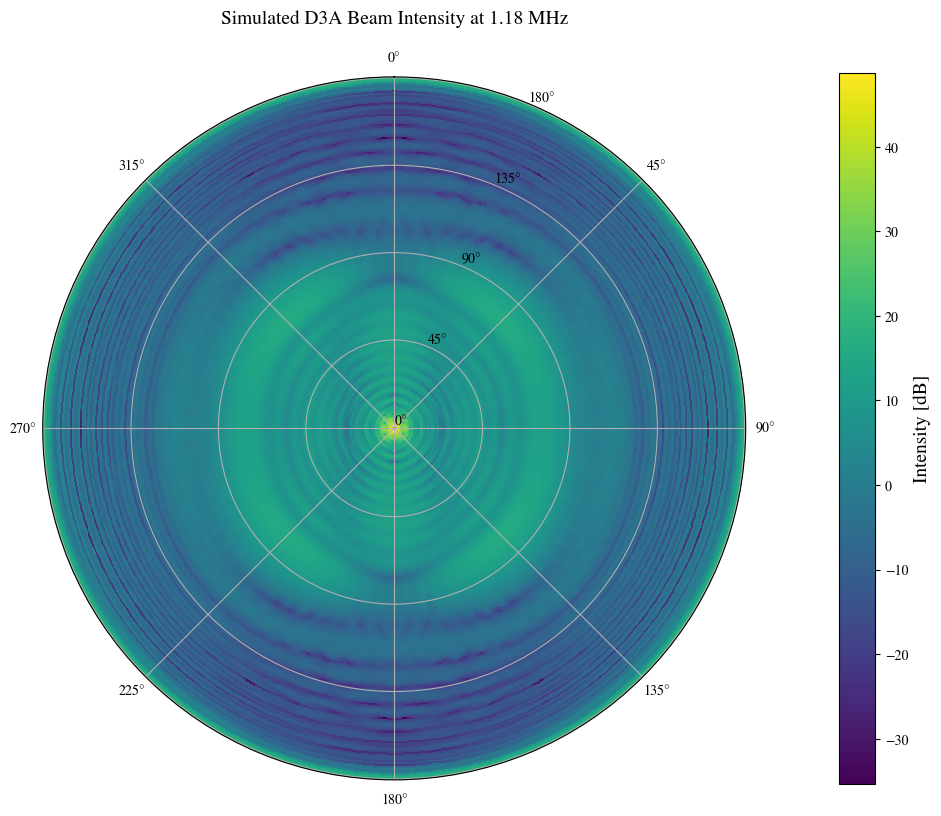

In [427]:
# sat_info = beam_map.save_satellite_arrays("G04")
# cnos = sat_info["matched"]["cnos"]
# elevs_deg = sat_info["matched"]["elevs_deg"]
# az_deg = sat_info["matched"]["az_deg"]
# times = sat_info["matched"]["times_elevs"]

# if not np.issubdtype(times.dtype, np.datetime64):
#     times = times.astype("datetime64[s]")

# dt = np.diff(times).astype("timedelta64[s]").astype(int)
# pass_breaks = np.where(dt > 200)[0] + 1
# pass_indices = np.split(np.arange(len(times)), pass_breaks)

# pass_number = np.argmax([len(p) for p in pass_indices])
# # using largest pass
# idx = pass_indices[pass_number]
# # if direction.lower() == "left":
# #     idx = idx[phi_shifted[idx] < D3A_AZ_deg]
# # else:
# #     idx = idx[phi_shifted[idx] > D3A_AZ_deg]

# phi_pass = az_deg[idx]
# theta_pass = theta_pass[idx]
# cnos = cnos[idx]
# 35 = 1.18 MHz
# 48 = 1.5 MHz
plot_raw_polar_beam(beam_power, freq_idx=35, db_scale=False, cmap='viridis', interp_now=False, matched_cnos=cnos, phi_pass=phi_pass, theta_pass=theta_pass)

(array([2924., 2279., 2272., 2246., 2331., 2350., 2430., 2496., 2571.,
        1645.]),
 array([ 3.35598733, 12.35596888, 21.35595042, 30.35593197, 39.35591351,
        48.35589506, 57.35587661, 66.35585815, 75.3558397 , 84.35582124,
        93.35580279]),
 <BarContainer object of 10 artists>)

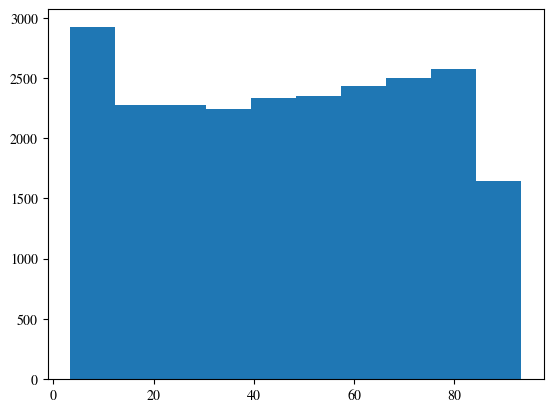

In [389]:
plt.hist(theta_pass)

In [73]:
np.shape(power_beam_sim.data_array)


(1, 4, 49, 181, 360)

In [327]:
def match_sat_all_passes(sat_name, left=False):
    sat_info = beam_map.save_satellite_arrays(sat_name)
    cnos = sat_info["matched"]["cnos"]
    elevs_deg = sat_info["matched"]["elevs_deg"]
    az_deg = sat_info["matched"]["az_deg"]
    times = sat_info["matched"]["times_elevs"]

    if not np.issubdtype(times.dtype, np.datetime64):
        times = times.astype("datetime64[s]")

    elevs_rad = np.radians(elevs_deg)
    az_rad = np.radians(az_deg)
    phi_pass_unshifted = az_deg
    phi_pass_shifted = beam_map.shift_az(phi_pass_unshifted)

    dt = np.diff(times).astype("timedelta64[s]").astype(int)
    gap_thresh = 60
    pass_breaks = np.where(dt > gap_thresh)[0] + 1
    pass_indices = np.split(np.arange(len(times)), pass_breaks)

    freq_idx = 48
    e_field = beam.data_array
    selected = e_field[:, 0, freq_idx, :, :]  # shape: (2, 181, 360)
    sim_power_beam = np.sum(np.abs(selected)**2, axis=0)  # shape: (181, 360)
    sim_power_beam_db = 10 * np.log10(sim_power_beam)

    theta_grid = beam.axis2_array  # [181]
    phi_grid = beam.axis1_array    # [360]
    interp_func = RegularGridInterpolator((theta_grid, phi_grid), sim_power_beam, bounds_error=False, fill_value=np.nan)

    for i, idx in enumerate(pass_indices):
        if left:
            idx = idx[phi_pass_shifted[idx] < D3A_AZ_deg]
        else:
            idx = idx[phi_pass_shifted[idx] > D3A_AZ_deg]

        if len(idx) == 0:
            continue

        phi_shifted = phi_pass_shifted[idx]
        elev_rad = np.radians(elevs_deg[idx])
        theta_pass = beam_map.convert_angular_distance_from_center_beam(elev_rad, np.radians(phi_shifted))
        phi_unshifted_rad = np.radians(beam_map.unshift_az(phi_shifted))
        sampled_power = interp_func(np.stack([theta_pass, phi_unshifted_rad], axis=1))
        sampled_power_db = 10 * np.log10(sampled_power)

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        axes[0].scatter(theta_pass * 180 / np.pi, cnos[idx], label="C/N₀ [dB-Hz]", s=0.1)
        axes[0].scatter(theta_pass * 180 / np.pi, sampled_power_db, label='Interpolated Beam Power', s=0.1)
        axes[0].set_xlabel("θ [deg]")
        axes[0].set_ylabel("Intensity [dB]")
        axes[0].legend()
        axes[0].set_title("SNR vs θ")
        axes[0].set_xlim(0, 20)

        axes[1].semilogy(theta_pass * 180 / np.pi, sampled_power_db)
        axes[1].set_xlabel("θ [deg]")
        axes[1].set_ylabel("Intensity [dB]")
        axes[1].set_title("Interpolated Beam Power")

        plt.tight_layout()
        label = "left" if left else "right"
        plt.savefig(f"/Users/sabrinaberger/Desktop/checking/{label}_match_{sat_name}_pass{i}.png")
        plt.close()


Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
Data has no positive values, and therefore cannot be log-scaled.


KeyboardInterrupt: 

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.


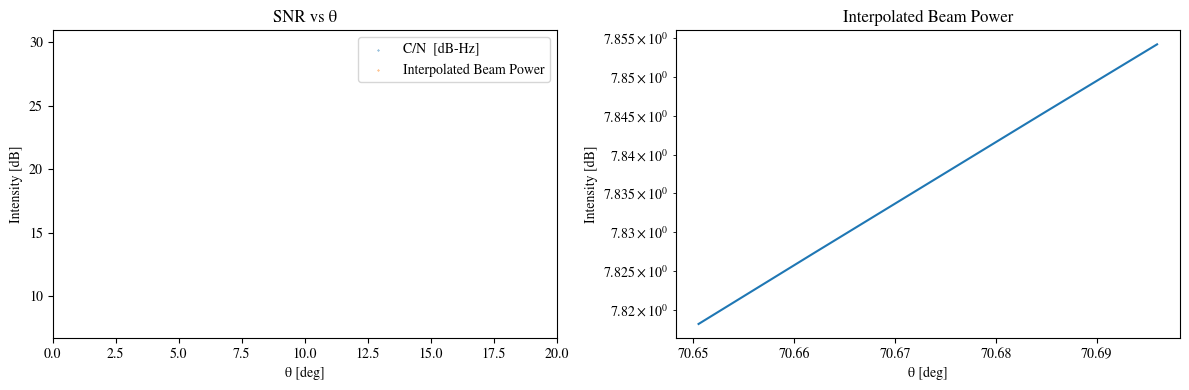

In [328]:
good_sats = ["G04", "G07", "G10", "G23", "G29", "G30", "E36", "E15"]
for key in beam_map.all_sat_dict:
    match_sat_all_passes(key)
    match_sat_all_passes(key, left=True)

85


In [534]:
def match_specified_passes(sat_pass_dir_list, save_dir=None, freq_idx = 48): # using default 1.5 GHz
    plt.close("all")
    e_field = beam.data_array
    selected = e_field[:, 0, freq_idx, :, :]
    sim_power_beam = np.sum(np.abs(selected)**2, axis=0)
    theta_grid = beam.axis2_array
    phi_grid = beam.axis1_array
    interp_func = RegularGridInterpolator((theta_grid, phi_grid), sim_power_beam, bounds_error=False, fill_value=np.nan)
    fig_num = 0 
    panel_idx = 0
    fig, axs = plt.subplots(4, 2, figsize=(12, 16))
    axs = axs.flatten()

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for sat_name, pass_number, direction in sat_pass_dir_list:
        sat_info = beam_map.save_satellite_arrays(sat_name)
        cnos = sat_info["matched"]["cnos"]
        print(cnos)
        elevs_deg = sat_info["matched"]["elevs_deg"]
        print(np.max(elevs_deg))
        az_deg = sat_info["matched"]["az_deg"]
        times = sat_info["matched"]["times_elevs"]

        if not np.issubdtype(times.dtype, np.datetime64):
            times = times.astype("datetime64[s]")

        phi_shifted = beam_map.shift_az(az_deg)

        dt = np.diff(times).astype("timedelta64[s]").astype(int)
        pass_breaks = np.where(dt > 60)[0] + 1
        pass_indices = np.split(np.arange(len(times)), pass_breaks)

        if pass_number == None:
            # Choose the longest pass (most indices)
            print(pass_number)
            pass_number = np.argmax([len(p) for p in pass_indices])


        idx = pass_indices[pass_number]
        if direction.lower() == "left":
            idx = idx[phi_shifted[idx] < D3A_AZ_deg]
        else:
            idx = idx[phi_shifted[idx] > D3A_AZ_deg]

        if len(idx) == 0:
            continue

        phi_this = phi_shifted[idx]
        elev_rad = np.radians(elevs_deg[idx])
        theta_pass = beam_map.convert_angular_distance_from_center_beam(elev_rad, np.radians(phi_this))

        theta_deg = np.rad2deg(theta_pass) # cut spurious stuff at the beginning        


        
        phi_unshifted_rad = np.radians(beam_map.unshift_az(phi_this))
        theta_pass = theta_pass
        
        sampled_power = interp_func(np.stack([theta_pass, phi_unshifted_rad], axis=1))
        sampled_power_db = 10 * np.log10(sampled_power)

        ax = axs[panel_idx]

        if direction=="Left":
            theta_pass = -theta_pass
            cnos_masked = cnos[idx]
            if sat_name == "R14":
                theta_deg_mask = theta_pass < -5.5 * np.pi / 180
                print(theta_pass)
                cnos_masked = cnos[idx][theta_deg_mask]
                theta_pass = theta_pass[theta_deg_mask]
                sampled_power_db = sampled_power_db[theta_deg_mask]
            ax.set_xlim(-20, np.max(theta_pass) * 180 / np.pi)

        else:
            cnos_masked = cnos[idx]
            ax.set_xlim(np.min(theta_pass) * 180 / np.pi + 1, 20)
        cnos_scale_factor = np.nanmax(cnos_masked) - np.nanmax(sampled_power_db)
        ax.scatter(theta_pass * 180 / np.pi, cnos_masked - cnos_scale_factor, label="GLONASS Satellite (~1.6 GHz)", s=0.4, c="green")
        ax.scatter(0.24 + theta_pass * 180 / np.pi, sampled_power_db, label='Offset Simulated 0.24 deg (1.5 GHz)', s=0.4, c="purple")
        ax.scatter(theta_pass * 180 / np.pi, sampled_power_db, label='Simulated (1.5 GHz)', s=0.4, c="purple", alpha=0.1)
        ax.set_xlabel("θ [deg]")
        ax.set_ylabel("Intensity [dB]")
        ax.set_title(f"{sat_name}") #Pass {pass_number}/{len(pass_indices)}")
        # ax.legend(fontsize=12)

        panel_idx += 1
        if panel_idx > 7:
            break

    if panel_idx > 0:
        for i in range(panel_idx, 8):
            fig.delaxes(axs[i])

        # Adjust layout to make room for top legend
        plt.subplots_adjust(top=0.93)
        plt.tight_layout()


        # Create shared legend handles
        legend_handles = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=6, label="GLONASS Satellite (~1.6 GHz)"),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=6, label="Offset Simulated 0.24 deg (1.5 GHz)"),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.1, markersize=6, label="True Simulated (1.5 GHz)")
        ]
        
        fig.legend(
            handles=legend_handles,
            loc='upper center',
            ncol=3,  # spread over 3 columns
            fontsize=13,
            frameon=True,
            bbox_to_anchor=(0.5, 1.02),  # raise a bit above plot
            columnspacing=2.5,  # more horizontal padding between columns
            handletextpad=1.5,  # space between marker and text
            borderaxespad=0.5  # padding between legend and axes
        )
        if save_dir:
            fname = os.path.join(save_dir, f"sat_pass_fig_{fig_num:02d}.png")
            plt.savefig(fname, dpi=300, bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

In [500]:
sat_pass_dir = [
    ("E04", 2, "Left"), ("E04", 14, "Right"), ("E27", 1, "Left"), ("E30", 0, "Right"),
    ("E31", 8, "Left"), ("G04", 0, "Left"), ("G04", 1, "Left"), ("G04", 4, "Left"),
    ("G22", 1, "Left"), ("G22", 6, "Left"), ("R03", 4, "Left"), ("R04", 3, "Left"),
    ("R05", 6, "Left"), ("R06", 13, "Left"), ("R07", 4, "Left"), ("R09", 0, "Right"),
    ("R11", 9, "Left"), ("R11", 1, "Right"), ("R12", 3, "Left"), ("R12", 8, "Left"),
    ("R13", 18, "Left"), ("R14", 8, "Left"), ("R17", 1, "Left"), ("R17", 8, "Left"),
    ("R18", 4, "Left"), ("R18", 9, "Left"), ("R23", None, "Right"), ("R24", 4, "Left")
]

sat_pass_dir = [
    ("R04",  3, "Left"),
    ("R05",  6, "Left"),
    ("R06", 13, "Left"),
    ("R11",  9, "Left"),
    ("R12",  8, "Left"),
    ("R14",  8, "Left"),
    ("R18",  4, "Left"),
    ("R18",  9, "Left"),
    ("R24",  4, "Left"),
    # ("R07", 4, "Left"),  # optional or excluded
]

# ("R07", 4, "Left")
match_specified_passes(sat_pass_dir, save_dir="/Users/sabrinaberger/Desktop/beam_paper_plots/panel_sims/")

[47.875  47.8125 47.9375 ... 28.625  29.3125 31.    ]
82.549995
[36.9375 39.5    38.5625 ... 30.5625 27.5    26.9375]
83.639999
[34.9375 35.1875 35.3125 ... 34.375  34.     33.9375]
88.040001
[34.0625 34.4375 34.8125 ... 20.1875 19.625  19.75  ]
84.720001
[35.0625 35.125  35.5    ... 20.0625 21.25   19.    ]
85.580002
[22.5625 22.5    23.4375 ... 20.9375 19.6875 19.375 ]
86.089996
[-1.41458638 -1.41458638 -1.41458638 ... -0.04310976 -0.04310976
 -0.04310976]
[33.8125 33.625  32.8125 ... 21.0625 19.8125 19.6875]
82.18
[33.8125 33.625  32.8125 ... 21.0625 19.8125 19.6875]
82.18


In [535]:
def plot_g04_enhanced(sat_pass_dir_list, save_dir=None, freq_idx=48, figsize=(10, 7)):
    """
    Create a beautiful, publication-ready plot for G04 satellite passes
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.interpolate import RegularGridInterpolator
    from collections import defaultdict
    import os
    
    # Set up professional plotting style
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'Computer Modern Roman'],
        'font.size': 12,
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'legend.framealpha': 0.95,
        'legend.edgecolor': 'black',
        'legend.fancybox': True,
        'figure.dpi': 100,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight'
    })
    
    plt.close("all")
    
    # Prepare beam data (assuming these variables exist in your context)
    e_field = beam.data_array
    selected = e_field[:, 0, freq_idx, :, :]
    sim_power_beam = np.sum(np.abs(selected)**2, axis=0)
    theta_grid = beam.axis2_array
    phi_grid = beam.axis1_array
    interp_func = RegularGridInterpolator((theta_grid, phi_grid), sim_power_beam, 
                                        bounds_error=False, fill_value=np.nan)

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Group by satellite name and find G04
    sat_dict = defaultdict(dict)
    for sat_name, pass_number, direction in sat_pass_dir_list:
        sat_dict[sat_name][direction.lower()] = pass_number

    if 'G04' not in sat_dict:
        print("G04 satellite not found in the provided list")
        return

    # Create the figure with professional styling
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Enhanced color palette
    colors = {
        'left': '#2E8B57',      # Sea Green
        'right': '#FF6B35',     # Vermillion Orange  
        'simulated': '#6A5ACD'  # Slate Blue
    }
    
    sat_name = 'G04'
    dirs = sat_dict[sat_name]
    
    # Process both directions
    theta_sim_all = []
    power_sim_all = []
    
    for direction in ["left", "right"]:
        if direction not in dirs:
            continue

        # Get satellite data (assuming beam_map exists in your context)
        sat_info = beam_map.save_satellite_arrays(sat_name)
        cnos = sat_info["matched"]["cnos"]
        elevs_deg = sat_info["matched"]["elevs_deg"]
        az_deg = sat_info["matched"]["az_deg"]
        times = sat_info["matched"]["times_elevs"]

        if not np.issubdtype(times.dtype, np.datetime64):
            times = times.astype("datetime64[s]")

        phi_shifted = beam_map.shift_az(az_deg)
        dt = np.diff(times).astype("timedelta64[s]").astype(int)
        pass_breaks = np.where(dt > 60)[0] + 1
        pass_indices = np.split(np.arange(len(times)), pass_breaks)

        pass_number = dirs[direction]
        if pass_number is None:
            pass_number = np.argmax([len(p) for p in pass_indices])

        idx = pass_indices[pass_number]
        if direction == "left":
            idx = idx[phi_shifted[idx] < D3A_AZ_deg]  # Assuming D3A_AZ_deg exists
        else:
            idx = idx[phi_shifted[idx] > D3A_AZ_deg]

        if len(idx) == 0:
            continue

        phi_this = phi_shifted[idx]
        elev_rad = np.radians(elevs_deg[idx])
        theta_pass = beam_map.convert_angular_distance_from_center_beam(elev_rad, np.radians(phi_this))
        theta_deg = np.rad2deg(theta_pass)

        phi_unshifted_rad = np.radians(beam_map.unshift_az(phi_this))
        sampled_power = interp_func(np.stack([theta_pass, phi_unshifted_rad], axis=1))
        sampled_power_db = 10 * np.log10(sampled_power)
        cnos_masked = cnos[idx]

        if direction == "left":
            theta_deg = -theta_deg

        # Align C/N₀ with simulation scale
        cnos_scale_factor = np.nanmax(cnos_masked) - np.nanmax(sampled_power_db)
        cnos_scaled = cnos_masked - cnos_scale_factor

        # Plot measured data with enhanced styling
        ax.scatter(theta_deg, cnos_scaled, 
                  label=f"{direction.capitalize()} Pass (1.6 GHz)", 
                  s=25, c=colors[direction], alpha=0.8, edgecolors='white', linewidth=0.5)

        # Store simulation data for plotting once
        theta_sim_all.extend(theta_deg)
        power_sim_all.extend(sampled_power_db)

    # Plot simulated beam data (only once)
    if theta_sim_all:
        ax.scatter(theta_sim_all, power_sim_all, 
                  label="Simulated Beam (1.5 GHz)", 
                  s=15, c=colors['simulated'], alpha=0.7, marker='^')

    # Enhanced styling
    ax.set_xlim(-25, 25)
    ax.set_xlabel('Angular Distance from Beam Center θ [°]', fontsize=14, fontweight='bold')
    ax.set_ylabel('Signal Intensity [dB]', fontsize=14, fontweight='bold')
    ax.set_title(f'G04 Satellite Pass Beam Pattern Comparison\nMeasured vs. Simulated Response', 
                fontsize=16, fontweight='bold', pad=20)

    # Enhanced grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax.set_axisbelow(True)

    # Professional legend
    legend = ax.legend(loc='upper right', fontsize=12, framealpha=0.95, 
                      edgecolor='black', fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('white')

    # Add subtle background color
    ax.set_facecolor('#FAFAFA')

    # Enhance tick labels
    ax.tick_params(axis='both', which='major', labelsize=11, width=1.2)
    ax.tick_params(axis='both', which='minor', width=0.8)

    # Add minor ticks
    ax.minorticks_on()

    # Tight layout
    plt.tight_layout()

    # Add annotation box with measurement info
    textstr = 'Measurement: ~1.6 GHz\nSimulation: 1.5 GHz\nBeam Pattern Analysis'
    props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    if save_dir:
        fname = os.path.join(save_dir, "G04_enhanced_beam_pattern.png")
        plt.savefig(fname, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Enhanced G04 plot saved to: {fname}")
        plt.close(fig)
    else:
        plt.show()

    return fig, ax


# Alternative version with even more sophisticated styling
def plot_g04_publication_ready(sat_pass_dir_list, save_dir=None, freq_idx=48):
    """
    Create a publication-ready plot with advanced styling
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    from scipy.interpolate import RegularGridInterpolator
    from collections import defaultdict
    import os
    
    # Publication-quality style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 11,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'legend.fontsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'figure.titlesize': 16,
        'axes.linewidth': 1.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 2,
        'patch.linewidth': 0.5,
        'xtick.major.width': 1.5,
        'ytick.major.width': 1.5,
        'xtick.minor.width': 1,
        'ytick.minor.width': 1,
        'mathtext.default': 'regular'
    })
    
    plt.close("all")
    
    # Your existing beam preparation code here...
    e_field = beam.data_array
    selected = e_field[:, 0, freq_idx, :, :]
    sim_power_beam = np.sum(np.abs(selected)**2, axis=0)
    theta_grid = beam.axis2_array
    phi_grid = beam.axis1_array
    interp_func = RegularGridInterpolator((theta_grid, phi_grid), sim_power_beam, 
                                        bounds_error=False, fill_value=np.nan)

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Find G04 data
    sat_dict = defaultdict(dict)
    for sat_name, pass_number, direction in sat_pass_dir_list:
        sat_dict[sat_name][direction.lower()] = pass_number

    if 'G04' not in sat_dict:
        print("G04 satellite not found")
        return

    # Create figure with golden ratio proportions
    fig, ax = plt.subplots(1, 1, figsize=(10, 6.18))
    
    # Sophisticated color scheme
    colors = {
        'left': '#1f77b4',      # Professional blue
        'right': '#ff7f0e',     # Professional orange
        'simulated': '#2ca02c'  # Professional green
    }
    
    # Process G04 data (your existing logic here)
    sat_name = 'G04'
    dirs = sat_dict[sat_name]
    
    # Add your data processing and plotting code here...
    # (Similar to the previous function but with the new styling)
    
    # Final professional touches
    ax.set_title('Satellite G04 Beam Pattern Analysis', fontsize=16, fontweight='bold', pad=25)
    ax.set_xlabel('Angular Distance θ [degrees]', fontsize=12)
    ax.set_ylabel('Normalized Signal Intensity [dB]', fontsize=12)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    plt.tight_layout()
    
    if save_dir:
        fname = os.path.join(save_dir, "G04_publication_ready.png")
        plt.savefig(fname, dpi=300, bbox_inches='tight', facecolor='white', 
                   edgecolor='none', transparent=False)
        print(f"Publication-ready G04 plot saved to: {fname}")
        plt.close(fig)
    else:
        plt.show()
    
    return fig, ax

In [537]:
good_sats = ["G04", "G07", "G10", "G23", "G29", "G30", "E36", "E15"]

sat_pass_dir_list.append(("G04", None, "Right"))
plot_g04_publication_ready(sat_pass_dir_list, save_dir="/Users/sabrinaberger/Desktop/beam_paper_plots/panel_sims/")

Publication-ready G04 plot saved to: /Users/sabrinaberger/Desktop/beam_paper_plots/panel_sims/G04_publication_ready.png


(<Figure size 1000x618 with 1 Axes>,
 <Axes: title={'center': 'Satellite G04 Beam Pattern Analysis'}, xlabel='Angular Distance θ [degrees]', ylabel='Normalized Signal Intensity [dB]'>)

In [471]:
import numpy as np

c = 3e8  # speed of light in m/s
D = 3.7  # dish diameter in meters
f1 = 1.5e9  # 1.5 GHz
f2 = 1.6e9  # 1.6 GHz

fwhm1 = 1.22 * c / (f1 * D) * 180 / np.pi  # in degrees
fwhm2 = 1.22 * c / (f2 * D) * 180 / np.pi  # in degrees

print(f"FWHM @ 1.5 GHz: {fwhm1:.2f} deg")
print(f"FWHM @ 1.6 GHz: {fwhm2:.2f} deg")
print(f"Ratio (1.6 / 1.5): {fwhm2 / fwhm1:.3f}")


FWHM @ 1.5 GHz: 3.78 deg
FWHM @ 1.6 GHz: 3.54 deg
Ratio (1.6 / 1.5): 0.937
